In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import matplotlib.pyplot as plt
import fitsio
import glob

import numpy as np
import healpy as hp
import xlens
import treecorr
import astropy.io.ascii as pyascii
import numpy.lib.recfunctions as rfn
from lsst.geom import degrees

field_list = ["spring1", "spring2", "spring3", "autumn1", "autumn2", "hectomap"]

In [15]:
data = []
for field in field_list:
    fname = f"/gpfs02/work/xiangchong.li/work/hsc_data/s23b/db_star/fields/{field}.fits"
    data.append(fitsio.read(fname))
data = rfn.stack_arrays(data, usemask=False)
snr = data["i_psfflux_flux"] / data["i_psfflux_fluxerr"]
nbins = 12
cor = treecorr.GGCorrelation(nbins=nbins, min_sep=0.25, max_sep=360.0, sep_units="arcmin")
ra = data["i_ra"]
dec = data["i_dec"]
psf_mxx = data["i_hsmpsfmoments_shape11"]
psf_myy = data["i_hsmpsfmoments_shape22"]
psf_mxy = data["i_hsmpsfmoments_shape12"]

e1p2 = (psf_mxx - psf_myy) / (psf_mxx + psf_myy)
e2p2 = psf_mxy / (psf_mxx + psf_myy) * 2.0

star_mxx = data["i_hsmsourcemoments_shape11"]
star_myy = data["i_hsmsourcemoments_shape22"]
star_mxy = data["i_hsmsourcemoments_shape12"]

e1s2 = (star_mxx - star_myy) / (star_mxx + star_myy)
e2s2 = star_mxy / (star_mxx + star_myy) * 2.0

e1p4 = (
    data["i_higherordermomentspsf_40"] -
    data["i_higherordermomentspsf_04"]
)
e2p4 = 2.0 * (
    data["i_higherordermomentspsf_31"] +
    data["i_higherordermomentspsf_13"]
)

e1s4 = (
    data["i_higherordermomentssource_40"] -
    data["i_higherordermomentssource_04"]
)
e2s4 = 2.0 * (
    data["i_higherordermomentssource_31"] +
    data["i_higherordermomentssource_13"]
)
msk = (~np.isnan(e1p2)) & (~np.isnan(e1s2)) & (~np.isnan(e1p4)) & (~np.isnan(e1s4)) & (data["i_calib_psf_reserved"]) & (snr>200.0)

ra = ra[msk]
dec = dec[msk]
e1p2 = e1p2[msk]
e2p2 = e2p2[msk]
e1p4 = e1p4[msk]
e2p4 = e2p4[msk]

e1s2 = e1s2[msk]
e2s2 = e2s2[msk]
e1s4 = e1s4[msk]
e2s4 = e2s4[msk]

catP2 = treecorr.Catalog(
    g1=e1p2, g2=-e2p2, 
    ra=ra, dec=dec, 
    ra_units="deg", 
    dec_units="deg"
)
catQ2 = treecorr.Catalog(
    g1=e1p2 - e1s2,
    g2=-(e2p2 - e2s2),
    ra=ra,
    dec=dec,
    ra_units="deg",
    dec_units="deg",
)

catP4 = treecorr.Catalog(
    g1=e1p4, g2=-e2p4, 
    ra=ra, dec=dec, 
    ra_units="deg", 
    dec_units="deg"
)
catQ4 = treecorr.Catalog(
    g1=e1p4 - e1s4,
    g2=-(e2p4 - e2s4),
    ra=ra,
    dec=dec,
    ra_units="deg",
    dec_units="deg",
)

# Define pairs to compute correlations
pairs = [
    ("P2", "P2"),
    ("P2", "P4"),
    ("P2", "Q2"),
    ("P2", "Q4"),
    ("P4", "P4"),
    ("P4", "Q2"),
    ("P4", "Q4"),
    ("Q2", "Q2"),
    ("Q2", "Q4"),
    ("Q4", "Q4"),
]

# Map names to actual catalogs
catalogs = {
    "P2": catP2,
    "P4": catP4,
    "Q2": catQ2,
    "Q4": catQ4,
}

# Dictionary to store results
res = {}
err = {}

for name1, name2 in pairs:
    cor = treecorr.GGCorrelation(nbins=nbins, min_sep=0.25, max_sep=360.0, sep_units="arcmin")
    cor.process(catalogs[name1], catalogs[name2])
    key = f"{name1}{name2}"
    res[key] = cor.xip
    err[key] = np.sqrt(cor.varxip / 2.0)

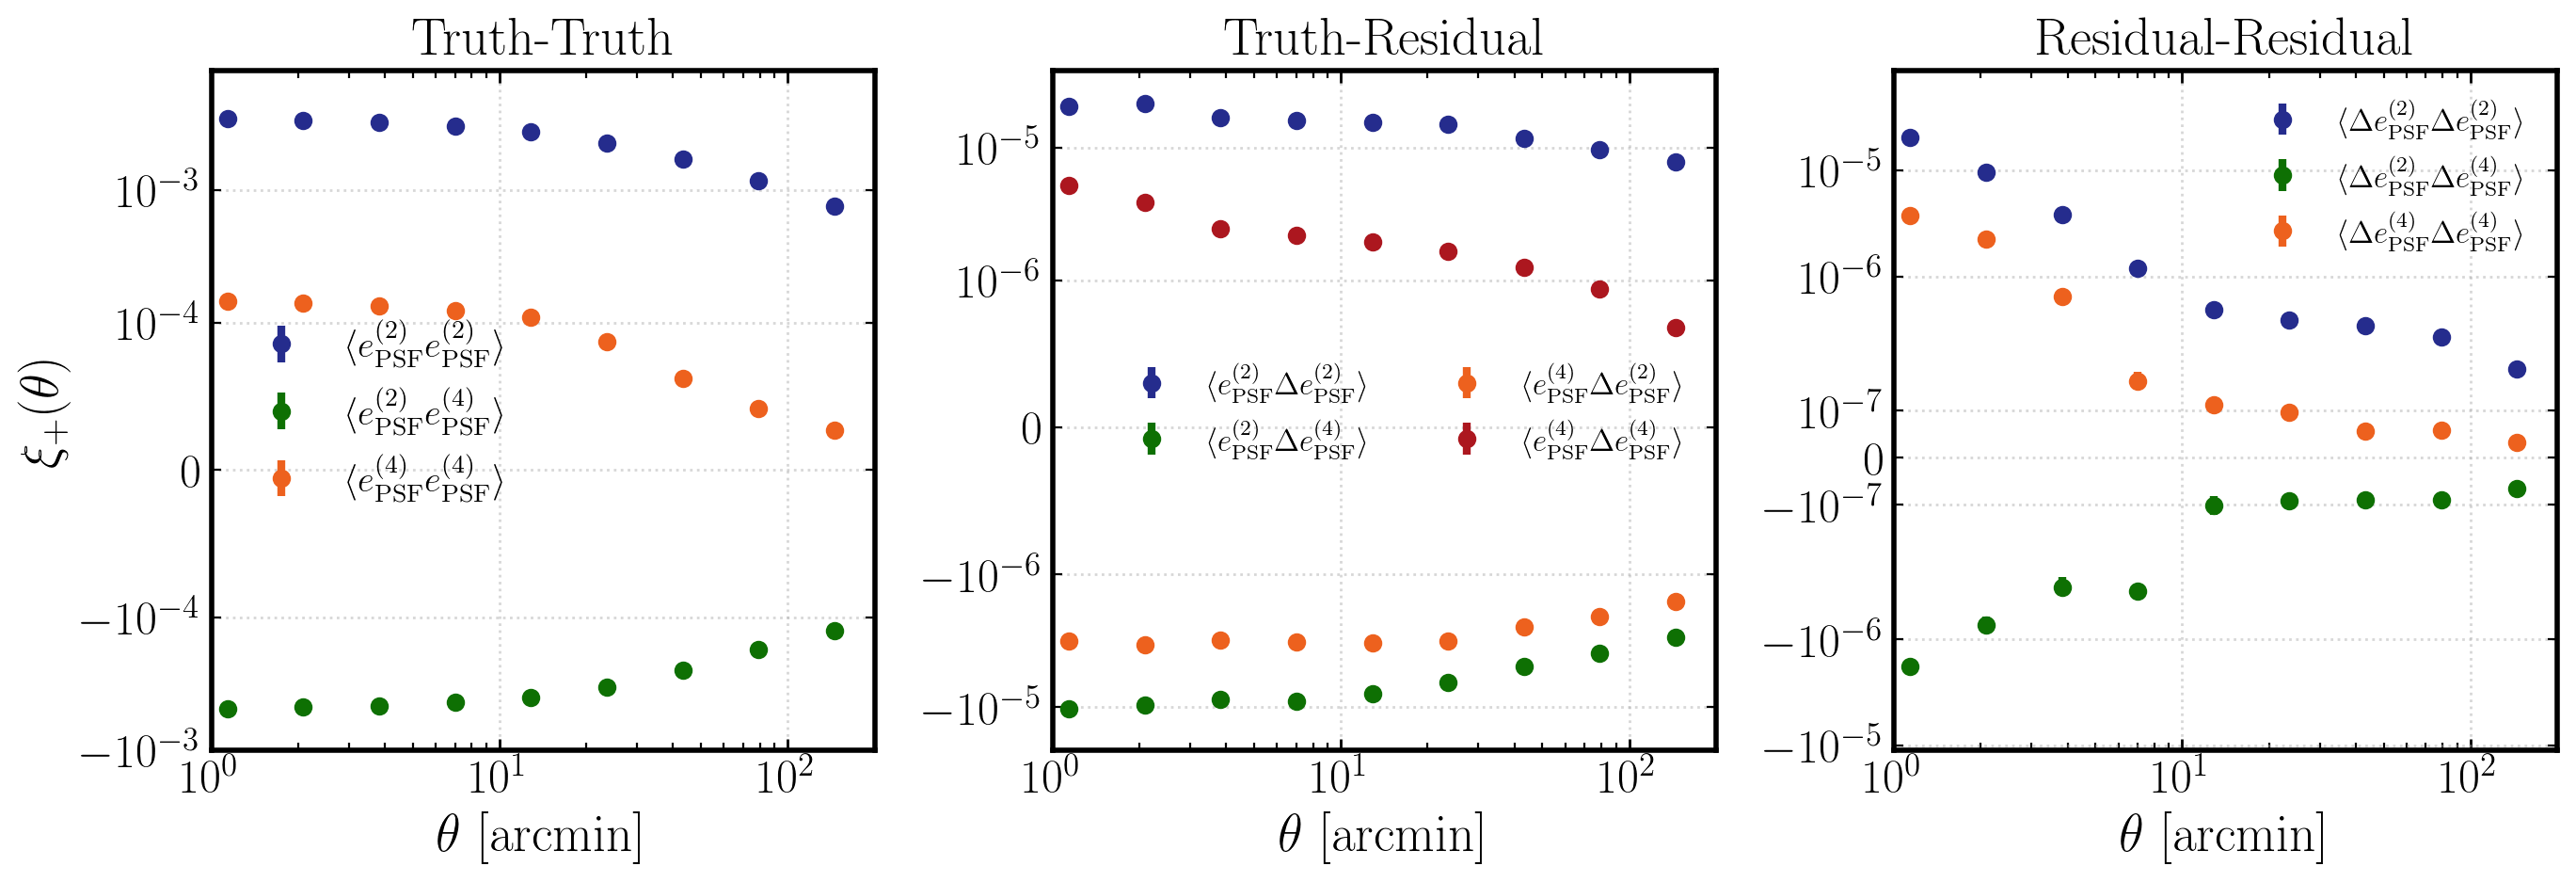

In [16]:
plt.close()
theta = cor.rnom
# Create figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(14, 5), sharex=True)

# --- Panel 1: Truth-Truth ---
ax = axes[0]
ax.errorbar(theta, res["P2P2"], yerr=err["P2P2"], fmt='o', label=r'$\langle e^{(2)}_{\rm PSF} e^{(2)}_{\rm PSF} \rangle$')
ax.errorbar(theta, res["P2P4"], yerr=err["P2P4"], fmt='o', label=r'$\langle e^{(2)}_{\rm PSF}e^{(4)}_{\rm PSF} \rangle$')
ax.errorbar(theta, res["P4P4"], yerr=err["P4P4"], fmt='o', label=r'$\langle e^{(4)}_{\rm PSF}e^{(4)}_{\rm PSF} \rangle$')
ax.set_title("Truth-Truth")
ax.set_xscale("log")
ax.set_yscale("symlog", linthresh=1e-4)
ax.set_xlim(1, 200)
ax.set_ylim(-1e-3, 8e-3)
ax.set_xlabel(r"$\theta$ [arcmin]")
ax.set_ylabel(r"$\xi_{+}(\theta)$")
ax.legend(fontsize=14, loc="center left", ncol=1, frameon=False)
ax.grid(True, linestyle=':')


# --- Panel 2: Truth-Residual ---
ax = axes[1]
ax.errorbar(theta, res["P2Q2"], yerr=err["P2Q2"], fmt='o', label=r'$\langle e^{(2)}_{\rm PSF}\Delta e^{(2)}_{\rm PSF} \rangle$')
ax.errorbar(theta, res["P2Q4"], yerr=err["P2Q4"], fmt='o', label=r'$\langle e^{(2)}_{\rm PSF}\Delta e^{(4)}_{\rm PSF} \rangle$')
ax.errorbar(theta, res["P4Q2"], yerr=err["P4Q2"], fmt='o', label=r'$\langle e^{(4)}_{\rm PSF}\Delta e^{(2)}_{\rm PSF} \rangle$')
ax.errorbar(theta, res["P4Q4"], yerr=err["P4Q4"], fmt='o', label=r'$\langle e^{(4)}_{\rm PSF}\Delta e^{(4)}_{\rm PSF} \rangle$')
ax.set_title("Truth-Residual")
ax.set_xscale("log")
ax.set_yscale("symlog", linthresh=1e-6)
ax.set_xlabel(r"$\theta$ [arcmin]")
ax.legend(fontsize=12, ncol=2, frameon=False)
ax.grid(True, linestyle=':')

# --- Panel 3: Residual-Residual ---
ax = axes[2]
ax.errorbar(theta, res["Q2Q2"], yerr=err["Q2Q2"], fmt='o', label=r'$\langle \Delta e^{(2)}_{\rm PSF}\Delta e^{(2)}_{\rm PSF} \rangle$')
ax.errorbar(theta, res["Q2Q4"], yerr=err["Q2Q4"], fmt='o', label=r'$\langle \Delta e^{(2)}_{\rm PSF}\Delta e^{(4)}_{\rm PSF} \rangle$')
ax.errorbar(theta, res["Q4Q4"], yerr=err["Q4Q4"], fmt='o', label=r'$\langle \Delta e^{(4)}_{\rm PSF}\Delta e^{(4)}_{\rm PSF} \rangle$')
ax.set_title("Residual-Residual")
ax.set_xscale("log")
ax.set_yscale("symlog", linthresh=2.5e-7)
ax.set_xlabel(r"$\theta$ [arcmin]")
ax.legend(fontsize=12, ncol=1, frameon=False)
ax.grid(True, linestyle=':')

plt.tight_layout()

In [17]:
# Matrix entry order: P2, P4, Q2, Q4
corr_labels = {
    ("P2", "P2"): "P2P2",
    ("P2", "P4"): "P2P4",
    ("P2", "Q2"): "P2Q2",
    ("P2", "Q4"): "P2Q4",
    ("P4", "P4"): "P4P4",
    ("P4", "Q2"): "P4Q2",
    ("P4", "Q4"): "P4Q4",
    ("Q2", "Q2"): "Q2Q2",
    ("Q2", "Q4"): "Q2Q4",
    ("Q4", "Q4"): "Q4Q4",
}

# Define variable names and initialize storage
vars = ["P2", "P4", "Q2", "Q4"]
n_bins = len(res["P2P2"])
matrices = []

# Loop over each angular bin
for i_bin in range(n_bins):
    mat = np.zeros((4, 4))
    for i in range(4):
        for j in range(4):
            key = tuple(sorted((vars[i], vars[j])))
            label = corr_labels.get(key)
            mat[i, j] = res[label][i_bin]
    matrices.append(mat)
    
inv_matrices = []
for mat in matrices:
    inv_matrices.append(np.linalg.inv(mat))
    
A = np.stack(inv_matrices)
pyfits.writeto("rho_mat_inv.fits", A, overwrite=True)

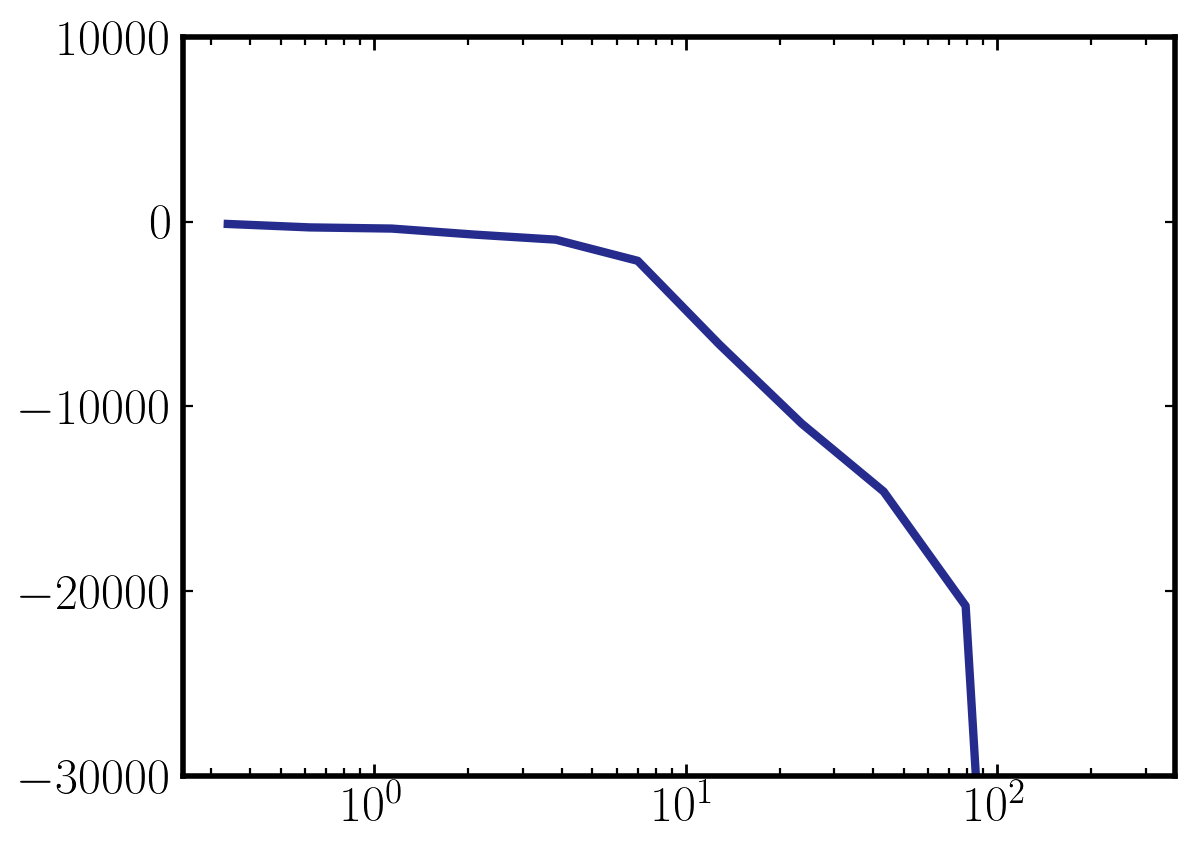

In [18]:
plt.plot(theta, A[:, 0, 2])
plt.ylim(-3e4, 1e4)
plt.xscale("log")

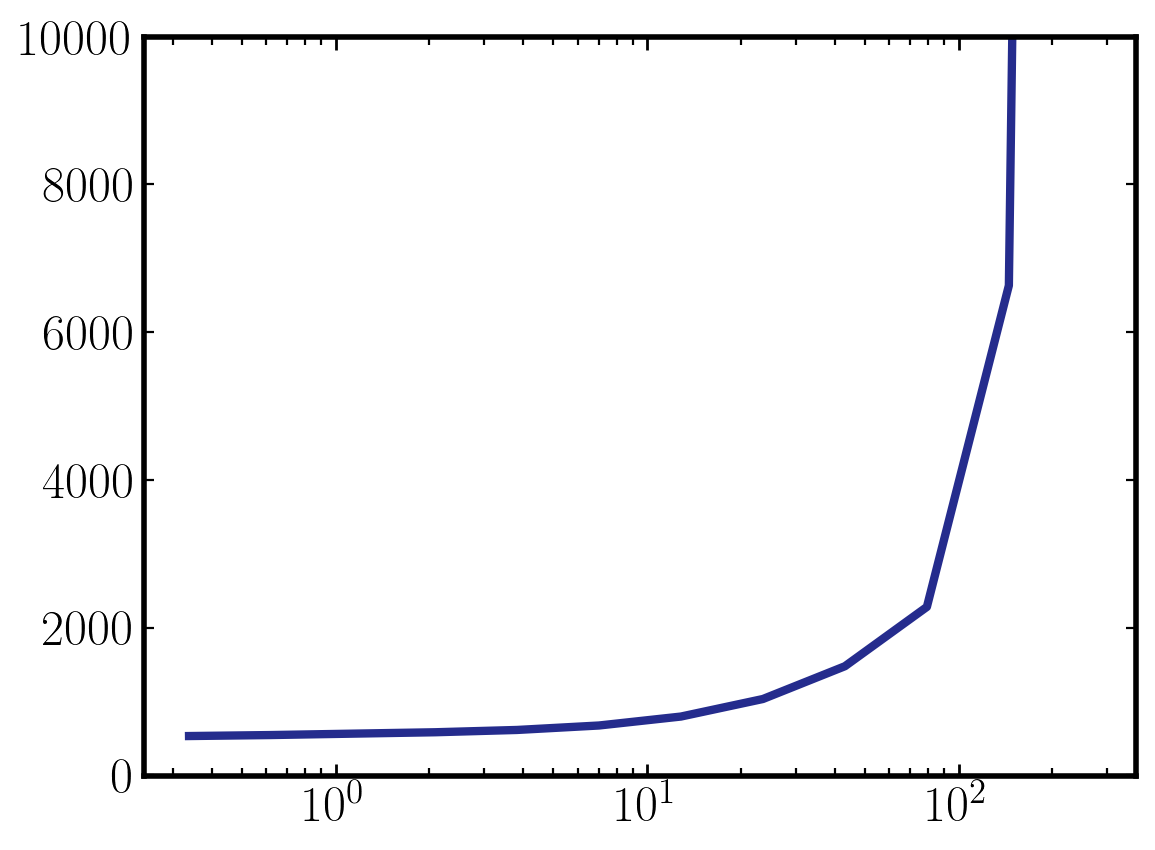

In [19]:
plt.plot(theta, A[:, 0, 0])
plt.ylim(-1e1, 1e4)
plt.xscale("log")

In [7]:
data = []
for field in field_list:
    fname = f"/gpfs02/work/xiangchong.li/work/hsc_data/s23b/deepCoadd_anacal2/fields/{field}.fits"
    data.append(fitsio.read(fname, columns=["e1", "de1_dg1", "e2", "de2_dg2", "ra", "dec", "wsel", "dwsel_dg1", "dwsel_dg2", "flux"]))
data = rfn.stack_arrays(data, usemask=False)
sel = ((27 - 2.5 * np.log(data["flux"])) < 25) & ((data["e1"] ** 2 + data["e2"] ** 2) < 0.09)
data = data[sel]
r1 = (
    data["de1_dg1"] * data["wsel"] +
    data["dwsel_dg1"] * data["e1"]
)
r2 = (
    data["de2_dg2"] * data["wsel"] +
    data["dwsel_dg2"] * data["e2"]
)
response = (r1 + r2) / 2.0

cate = treecorr.Catalog(
    g1=data["e1"] * data["wsel"],
    g2=-data["e2"] * data["wsel"],
    ra=data["ra"],
    dec=data["dec"],
    ra_units="deg",
    dec_units="deg",
)
catk = treecorr.Catalog(
    k=response,
    ra=data["ra"],
    dec=data["dec"],
    ra_units="deg",
    dec_units="deg",
)

In [20]:
out = {}
for kk in catalogs.keys():
    cor1 = treecorr.GGCorrelation(nbins=nbins, min_sep=0.25, max_sep=360.0, sep_units="arcmin")
    cor2 = treecorr.NKCorrelation(nbins=nbins, min_sep=0.25, max_sep=360.0, sep_units="arcmin")
    cor1.process(catalogs[kk], cate)
    cor2.process(catalogs[kk], catk)
    out[kk] = cor1.xip / cor2.xi
dd =[]
for kk in out.keys():
    dd.append(out[kk])
dd = np.stack(dd).T
fff = np.zeros((len(dd), 4))
for i in range(nbins):
    fff[i] = A[i] @ dd[i]
fff = fff.T

In [26]:
cor2.xi

array([0.24077746, 0.2416488 , 0.24174917, 0.24176305, 0.24163932,
       0.2417681 , 0.24171251, 0.24176159, 0.2418432 , 0.24205767,
       0.24239732, 0.24259986])

In [30]:
np.average(catk.k)

0.24360357928500392

In [27]:
np.average(res)

TypeError: unsupported operand type(s) for /: 'dict' and 'int'

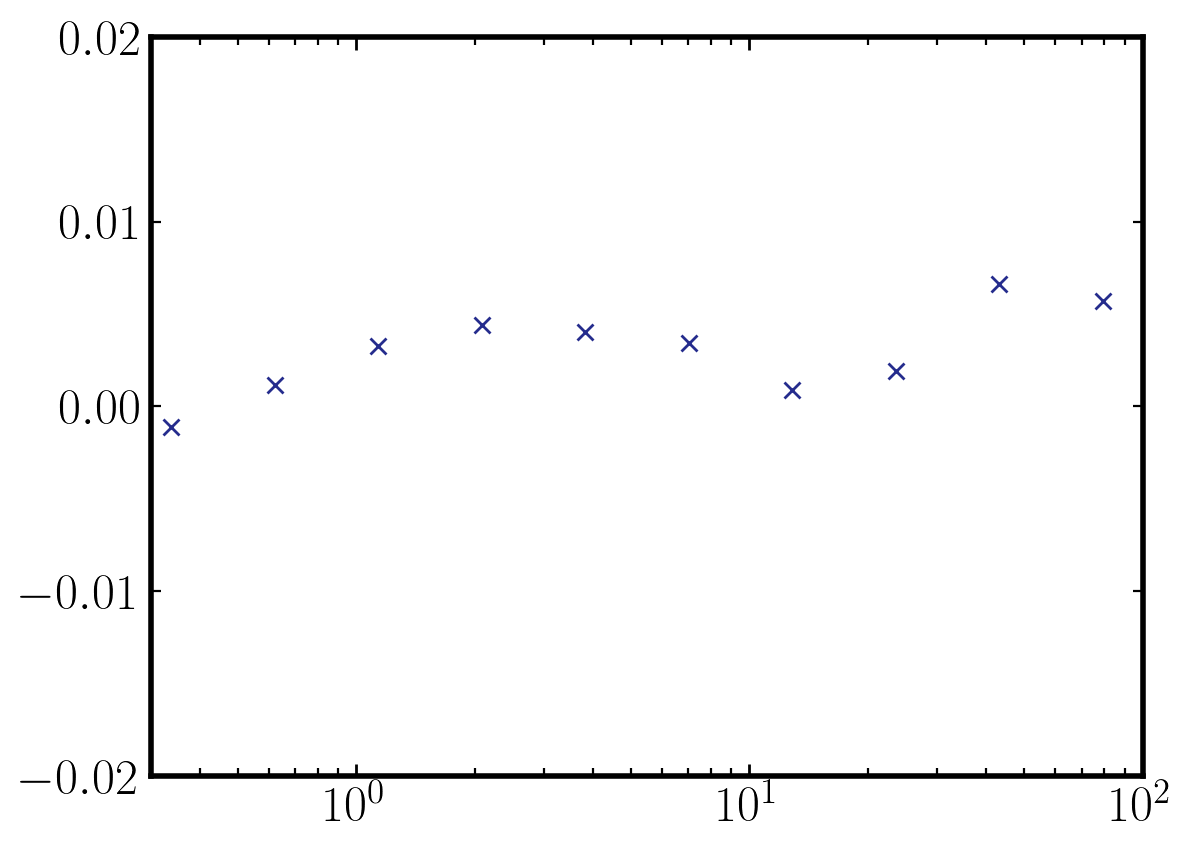

In [21]:
plt.plot(theta, fff[0], "x", ls="")
plt.ylim(-0.02, 0.02)
plt.xlim(0.3, 100)
plt.xscale("log")

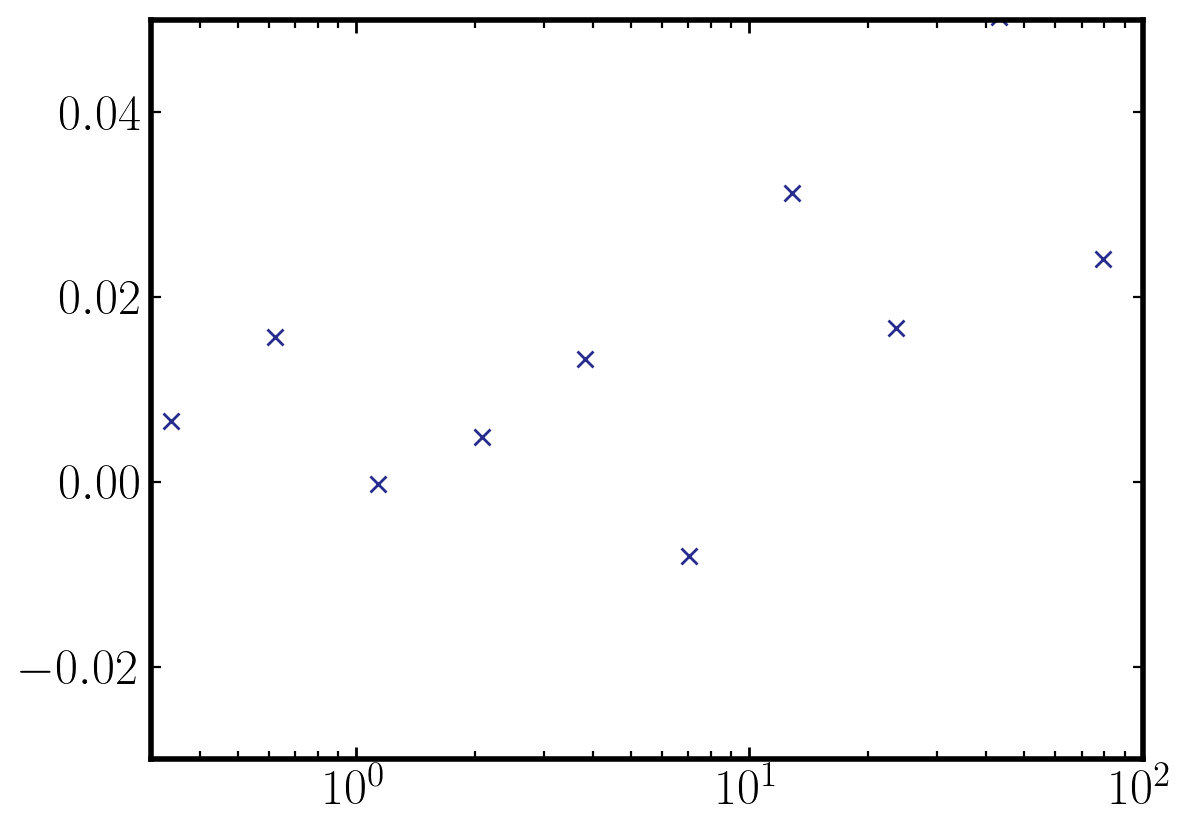

In [22]:
plt.plot(theta, fff[1], "x", ls="")
plt.ylim(-0.03, 0.05)
plt.xlim(0.3, 100)
plt.xscale("log")

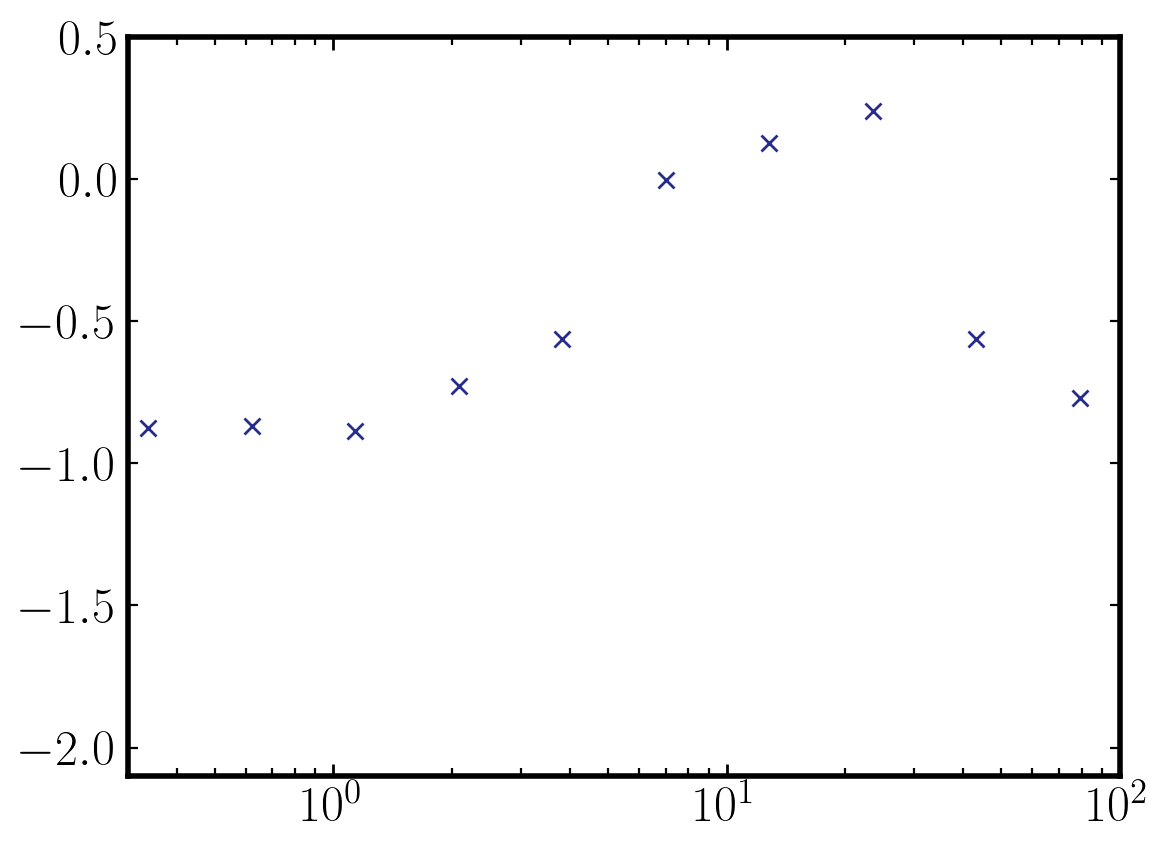

In [23]:
plt.plot(theta, fff[2], "x", ls="")
plt.ylim(-2.1, 0.5)
plt.xlim(0.3, 100)
plt.xscale("log")

In [25]:
cor.npairs

array([1.93360000e+04, 6.49960000e+04, 2.13822000e+05, 7.09108000e+05,
       2.34589000e+06, 7.70736800e+06, 2.52492580e+07, 8.22920680e+07,
       2.61781186e+08, 7.92206320e+08, 2.17063649e+09, 4.68779389e+09])

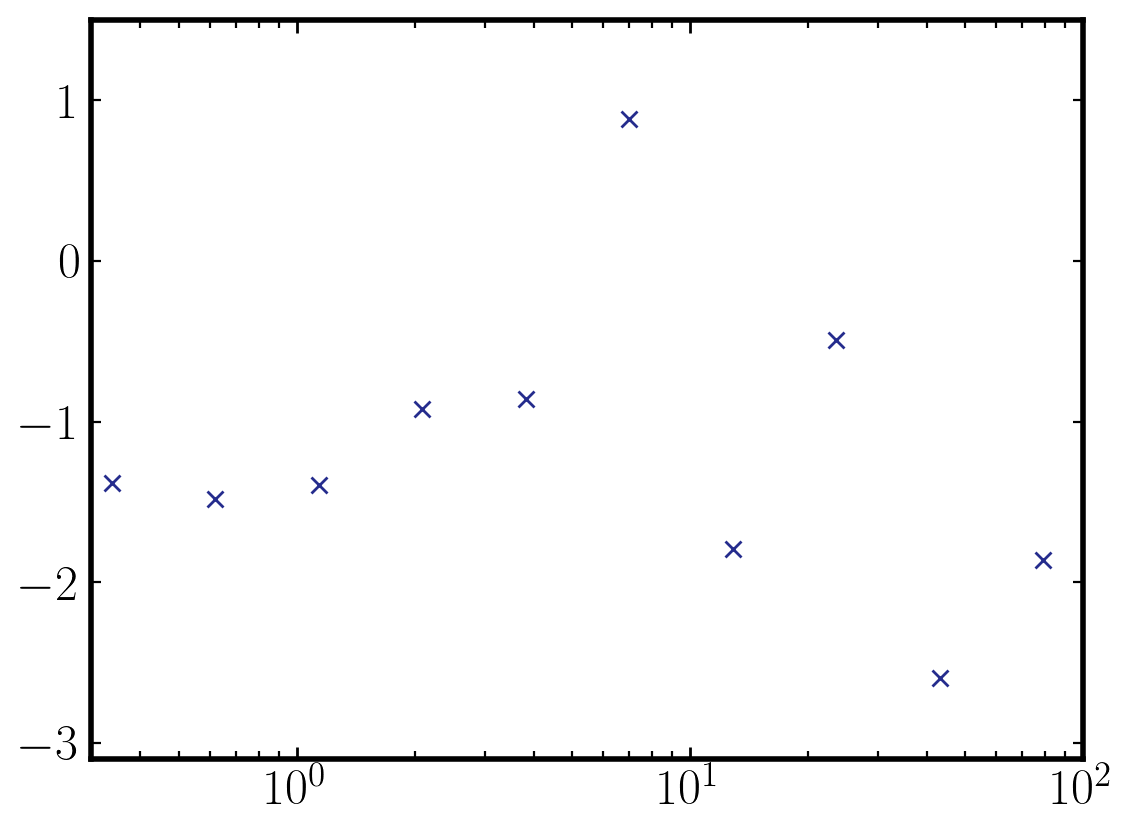

In [24]:
plt.plot(theta, fff[3], "x", ls="")
plt.ylim(-3.1, 1.5)
plt.xlim(0.3, 100)
plt.xscale("log")

In [14]:
alphabetas = fitsio.read("/gpfs02/work/xiangchong.li/work/hsc_data/s23b/deepCoadd_anacal2/psfstar.fits")

OSError: FITSIO status = 104: could not open the named file
failed to find or open the following file: (ffopen)
/gpfs02/work/xiangchong.li/work/hsc_data/s23b/deepCoadd_anacal2/psfstar.fits


In [ ]:
out = np.average(alphabetas, axis=0)

In [ ]:
plt.plot(theta, out[1], "x", ls="")
plt.ylim(-0.04, 0.2)
plt.xlim(0.3, 100)
plt.xscale("log")